# Mini-Projeto LSTM
## Centro de Informática da UFPE
### IF702 - Redes Neurais
### Prof. Germano Crispim Vasconcelos

10/02/2025

Grupo:
1. Pedro Lima (pbsl@cin.ufpe.br)
2. Pedro de Souza (pbsl@cin.ufpe.br)
3. Pedro Barros (pbsl@cin.ufpe.br)


# Imports e Downloads

As principais bibliotecas Python utilizadas para esta atividade foram:

- Pandas
- Numpy
- Pytorch

In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# Bitcoin price prediction

### Dataset
O dataset coletado foi o do preço do Bitcoin ao longo do tempo. Ele foi coletado através do [repositório do github](https://github.com/brianmwangy/predicting-bitcoin-prices-using-LSTM.git) recomendado nos slides de introdução ao projeto.

In [2]:
# Coletando os dados do arquivo e convertendo o tipo da coluna de datas
df = pd.read_csv('btc.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,2018-05-26,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,2018-05-25,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,2018-05-24,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,2018-05-23,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,2018-05-22,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [3]:
# Ordenando os preços por ordem cronológica
df = df.sort_values(by='Date')
df = df.reset_index().drop(columns=['index'])
df.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,2014-12-01,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1,2014-12-02,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
2,2014-12-03,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
3,2014-12-04,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
4,2014-12-05,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


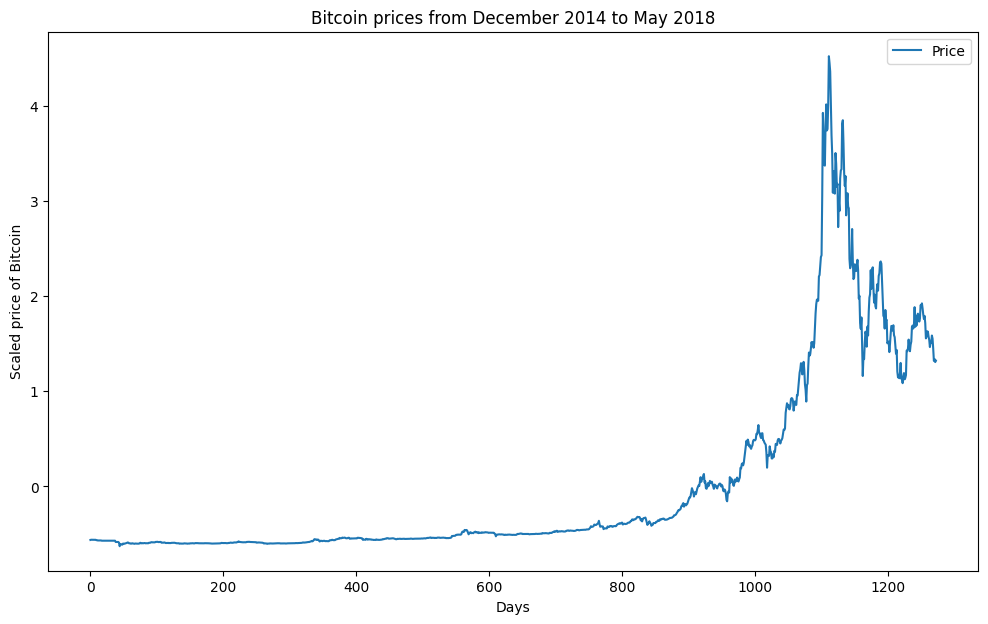

In [4]:
# Coluna dos preços ao fechamento do dia
data_to_use=df['Close'].values
# Normalização dos dados
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
# Plotando os preços
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

Como o repositório recomendado tinha sido feito com o Tensorflow, decidi usar o Pytorch, já que eu tenho mais experiência com essa biblioteca e porque eu poderia aprender como se monta uma rede com LSTM usando Pytorch.

In [5]:
def lookback_data(data, lookback):
    X, y = [], []

    for i in range(len(data)-lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+1:i+lookback+1])

    assert len(X) == len(y)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

A separação entre dados de treinamento e teste deve vir antes da separação dos
atributos de entrada e de saída, para garantir, com mais facilidade, que não
vão haver instâncias em comum entre os conjuntos de treinamento e de teste.

In [86]:
LOOKBACK = 10

# Separação dos dados de treinamento e de teste
train_idx = int(len(scaled_data)*0.8)
df_train = scaled_data[:train_idx]
df_test = scaled_data[train_idx:]

# Separação dos dois subconjuntos em atributos de saída e entrada
X_train, y_train = lookback_data(df_train, LOOKBACK)
X_test, y_test = lookback_data(df_test, LOOKBACK)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

# Criação dos DataLoaders de treinamento e teste
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=7)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=True, batch_size=7)

X_train size: torch.Size([1008, 10, 1])
y_train size: torch.Size([1008, 10, 1])
X_test size: torch.Size([245, 10, 1])
y_test size: torch.Size([245, 10, 1])


In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

### Classe do modelo LSTM

In [8]:
class LSTModel(nn.Module):
    def __init__(self, hidden_size=256, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

### Treinamento e Testes:

In [9]:
def train_net(model, tloader, vloader, num_epochs, optimizer, lossFunc=nn.MSELoss(), delta=None, patience=None, verbose=2):
    train_losses = []
    test_losses = []
    best_train_score = None
    best_val_score = None
    for e in range(num_epochs):
        train_loss = 0.0 # total loss during single epoch training
        val_loss = 0.0
        model.train()
        for i, (X_batch, y_batch) in enumerate(tloader):
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            pred = model(X_batch) # predictions based on batch X_batch
            loss = lossFunc(pred, y_batch)  # calculates the loss function result
            optimizer.zero_grad() # clears x.grad for every parameter x in the optimizer.
            loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x
            optimizer.step() # updates the value of x using the gradient x.grad

            train_loss += loss.item()
            l = np.sqrt(loss.item()) # rmse loss
            train_loss += l # value of loss?
            #print(f'Epoch [{e + 1}/{num_epochs}], Step [{i + 1}/{len(tloader)}], Loss: {l:.4f} ')

        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in vloader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                pred = model(X_batch)
                l = np.sqrt(lossFunc(pred, y_batch).item()) #rmse loss
                val_loss += l

            avg_train_loss = train_loss / len(tloader)
            avg_val_loss = val_loss / len(vloader)
            if(verbose >= 1):
                print(f'Epoch [{e + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_val_loss:.4f}')
        train_losses.append(avg_train_loss)
        test_losses.append(avg_val_loss)

        # Armazenamento do melhor modelo com base no score de validação
        if((best_val_score is None) or (best_val_score > avg_val_loss)):
                    best_val_score = avg_val_loss
                    best_e = e
                    best_model = model
                    if(verbose >= 2):
                        print('best_model updated')

        # Early stopping com base no score de treinamento
        if((delta is not None) and (patience is not None)):
            if((best_train_score is None) or (best_train_score-avg_train_loss >= delta)):
                counter = 0
                best_train_score = avg_train_loss
            else:
                counter += 1
                if(counter>=patience):
                    if(verbose >= 2):
                        print("Early Stopping!")
                    break

    return best_model, best_e, (train_losses, test_losses)

In [92]:
lstm = LSTModel().to(DEVICE)
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0001)
lstm, best_e, results = train_net(lstm, train_loader, test_loader, 200, optimizer, delta=0.007, patience=30)

Epoch [1/200], Train Loss: 0.4050, Eval Loss: 1.9454
best_model updated
Epoch [2/200], Train Loss: 0.2496, Eval Loss: 1.6136
best_model updated
Epoch [3/200], Train Loss: 0.1780, Eval Loss: 1.3529
best_model updated
Epoch [4/200], Train Loss: 0.1490, Eval Loss: 1.2152
best_model updated
Epoch [5/200], Train Loss: 0.1301, Eval Loss: 1.1181
best_model updated
Epoch [6/200], Train Loss: 0.1146, Eval Loss: 1.0198
best_model updated
Epoch [7/200], Train Loss: 0.1015, Eval Loss: 0.9287
best_model updated
Epoch [8/200], Train Loss: 0.0906, Eval Loss: 0.8673
best_model updated
Epoch [9/200], Train Loss: 0.0812, Eval Loss: 0.8150
best_model updated
Epoch [10/200], Train Loss: 0.0732, Eval Loss: 0.7700
best_model updated
Epoch [11/200], Train Loss: 0.0670, Eval Loss: 0.7274
best_model updated
Epoch [12/200], Train Loss: 0.0605, Eval Loss: 0.7125
best_model updated
Epoch [13/200], Train Loss: 0.0553, Eval Loss: 0.6743
best_model updated
Epoch [14/200], Train Loss: 0.0513, Eval Loss: 0.6661
best_m

In [93]:
print(f'''RMSE
- Train Loss: {results[0][best_e]:.4f}
- Test Loss: {results[1][best_e]:.4f}
''')

RMSE
- Train Loss: 0.0121
- Test Loss: 0.2489



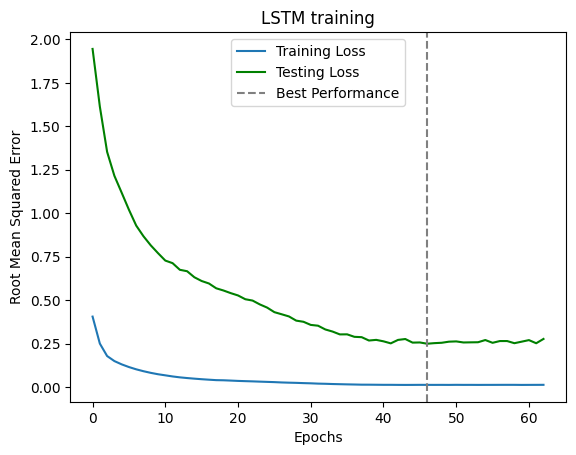

In [94]:
# Plotando curva da perda durante o treinamento
plt.title('LSTM training')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.plot(results[0], label='Training Loss')
plt.plot(results[1], label='Testing Loss', c='green')
plt.axvline(x=best_e, c='gray', linestyle='dashed', label='Best Performance')
plt.legend()
plt.show()

In [95]:
# Arrays para o gráfico das previsões
pred_list = [np.NAN]*LOOKBACK + list((lstm(X_train.to(DEVICE))[:,-1,:].to('cpu'))[:,0].detach().numpy()) + [np.NAN]*(LOOKBACK-1) + list((lstm(X_test.to(DEVICE))[:,-1,:].to('cpu'))[:,0].detach().numpy())
plt_train = list(X_train[0,:-1,0]) + list(X_train[:,-1,0])
plt_test = [np.NAN]*(len(plt_train)) + list(X_test[0,:-1,0]) + list(X_test[:,-1,0])

O array pred_list precisa desses espaços em branco porque são correspondentes aos
itens da primeira janela de recorrência, e queremos saber apenas o que o
modelo extrapola. O segundo intervalo de espaços em branco tem 1 NaN a menos
porque o modelo previu +1 valor fora do conjunto de treinamento, que se
encaixa na posição do primeiro valor vazio do intervalo da janela de
recorrência do conjunto de testes, e se não tirar esse único NaN, as previsões
todas vão ficar deslocadas 1 posição na frente.

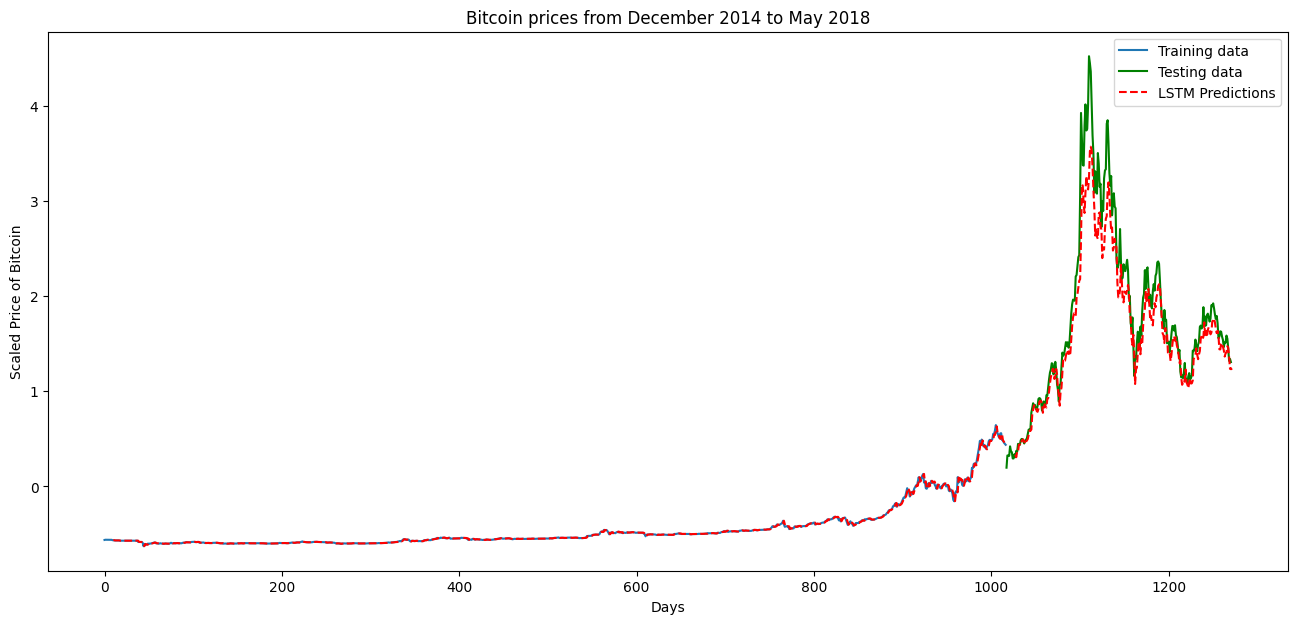

In [96]:
# Plotando as previsões da rede
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')

# (Apenas para teste)
#all_data = list(X_train[0,:-1,0]) + list(X_train[:,-1,0]) + list(X_test[0,:-1,0]) + list(X_test[:,-1,0])
#plt.plot(all_data, label='Original data')

plt.plot(plt_train, label='Training data')#, linestyle='dashed')
plt.plot(plt_test, label='Testing data', c='green')#, linestyle='dashed')
plt.plot(pred_list, label='LSTM Predictions', c='red', linestyle='dashed')
plt.legend()
plt.show()

## Histórico de testes

### V0

**Parâmetros:**

- lookback = 7
- batch_size = 7
- epochs = 60
- função de perda = Root Mean Squared Loss
- otimizador = adam
- taxa de aprendizado = 0.001
- nº de features ocultas = 60

**Performance:**

- Train Loss: 0.0129
- Test Loss: 0.4316

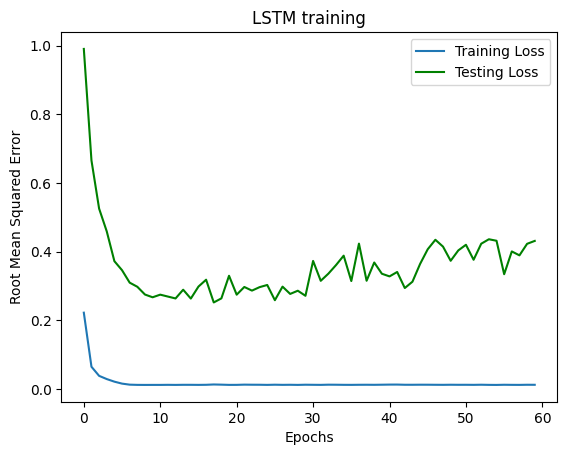

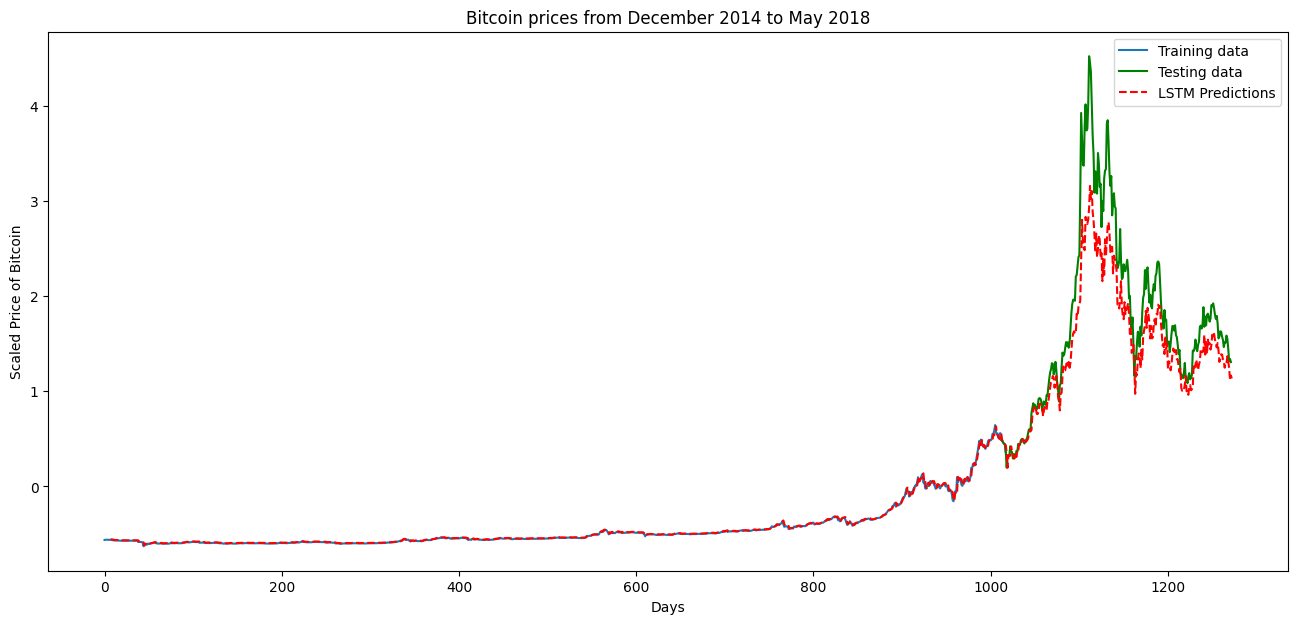

  ---

### V1

Durante o treinamento, a perda começou a subir depois de descer por um tempo, então vou salvar o melhor modelo durante o treinamento, com base na perda do conjunto de teste

**Parâmetros:**

(Não mudou)

**Performance:**

- Train Loss: 0.0132
- Test Loss: 0.2456


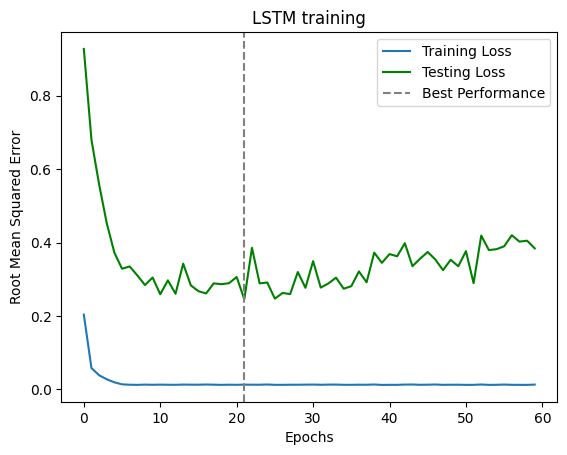

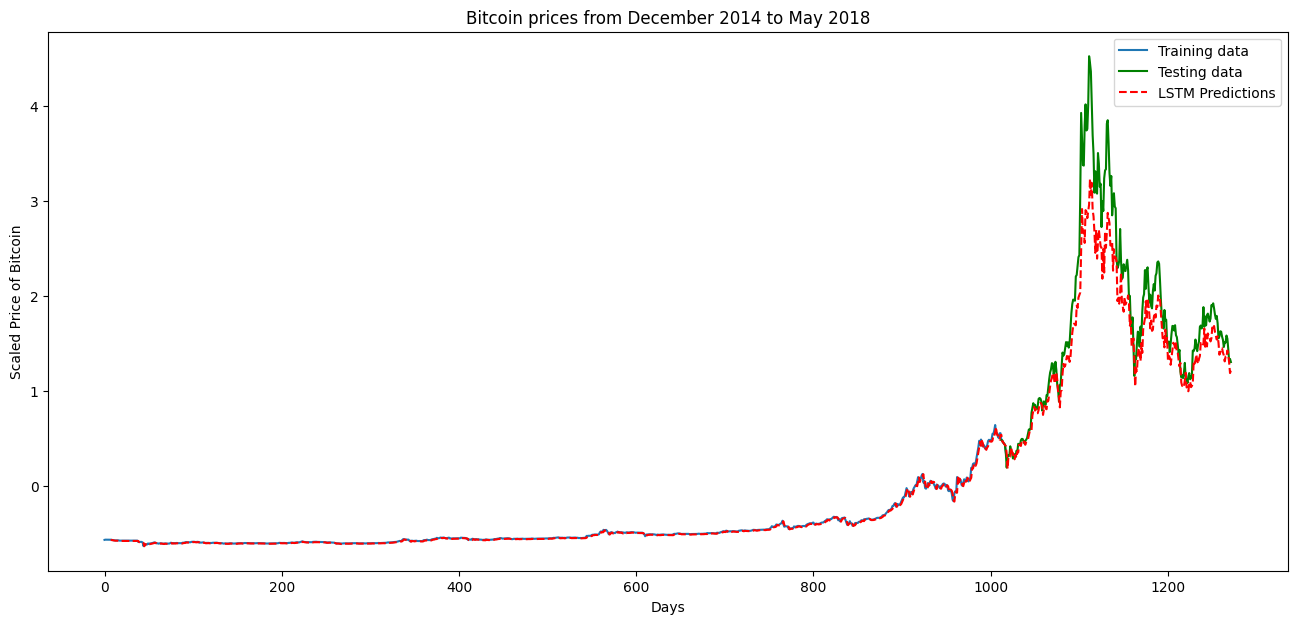

---

### V2

Vou tentar diminuir o "lookback" (não acho que seja esse o nome) e aumentar um pouco a taxa de aprendizado para ver se as últimas instâncias do dataset (onde o preço começa a subir) receberão maior peso no treinamento, assim podendo prever melhor o conjunto de teste.

**Parâmetros:**

- lookback: 3
- taxa de aprendizado: 0.01

**Performance:**

- Train Loss: 0.0174
- Test Loss: 0.3516

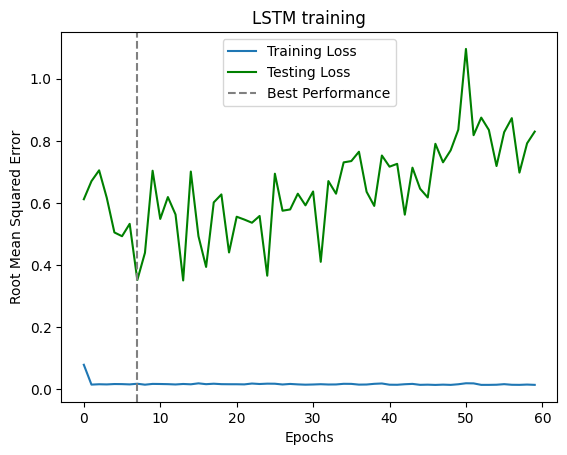

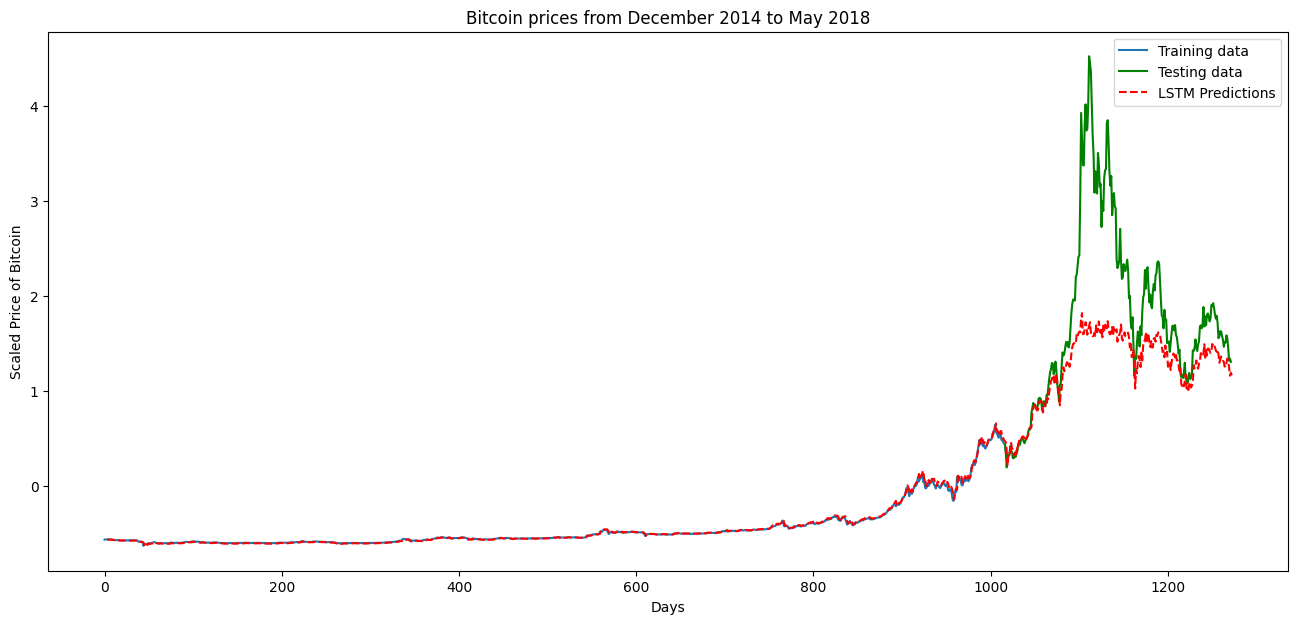

---

### V3

O modelo piorou muito, também testei sem mudar a taxa de aprendizado e também deu uma queda na performance, mas o gráfico da perda no conjunto de teste indica que a queda é devido a uma taxa de aprendizado muito alta. Vou diminuir a taxa de aprendizado (também corrigi o código da parada do early stopping, não alterava os resultados, só que quase nunca parava quando devia).

**Parâmetros**

- taxa de aprendizado = 0.0005
- epochs = 200 (16 pelo early stopping)
- early_stopping:
    - delta = 0.01
    - paciência = 10

**Performance:**

- Train Loss: 0.0126
- Test Loss: 0.2734

Também treinei a mesma rede sem early stopping, para garantir que ele não estava afetando negativamente a performance. Os resultados não mostraram uma melhora do modelo, ao invés disso, a curva do RMSE no conjunto de treinamento começou a subir pouco tempo depois, indicando overfitting, como imaginado.

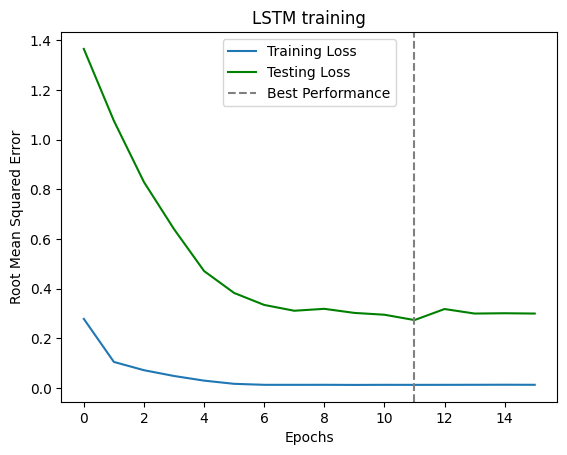

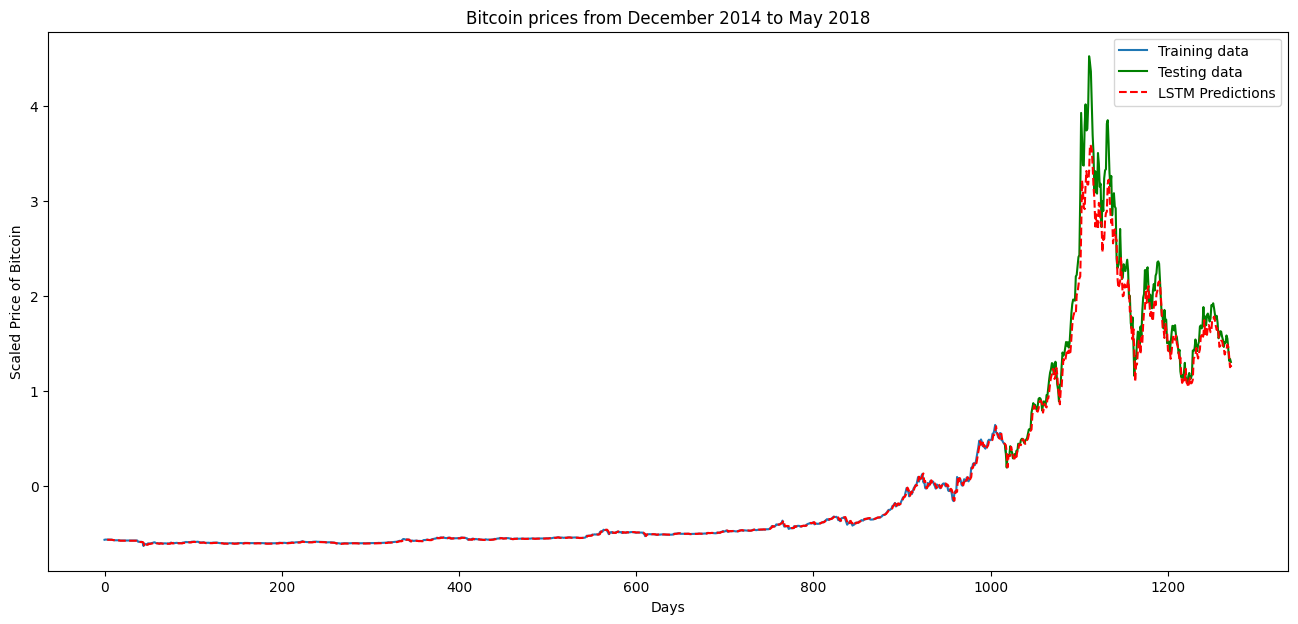

---

### V4

Já que o modelo apresentou uma melhora quando diminui a taxa de aprendizado, vou tentar diminuir um pouco mais.

**Parâmetros:**

- taxa de aprendizado = 0.00005
- early stopping:
    - delta = 0.007
    - paciência = 20

**Performance:**

- Train Loss: 0.0121
- Test Loss: 0.3301


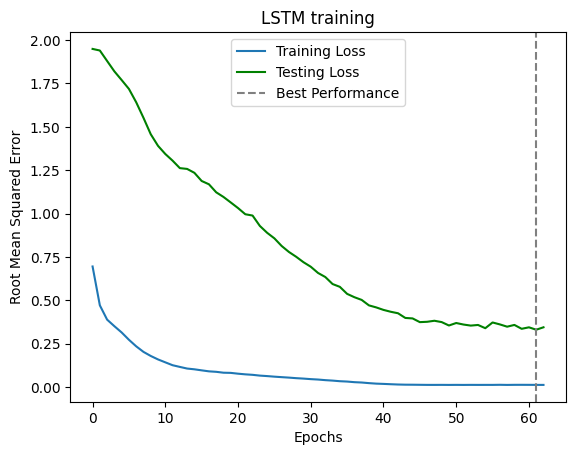

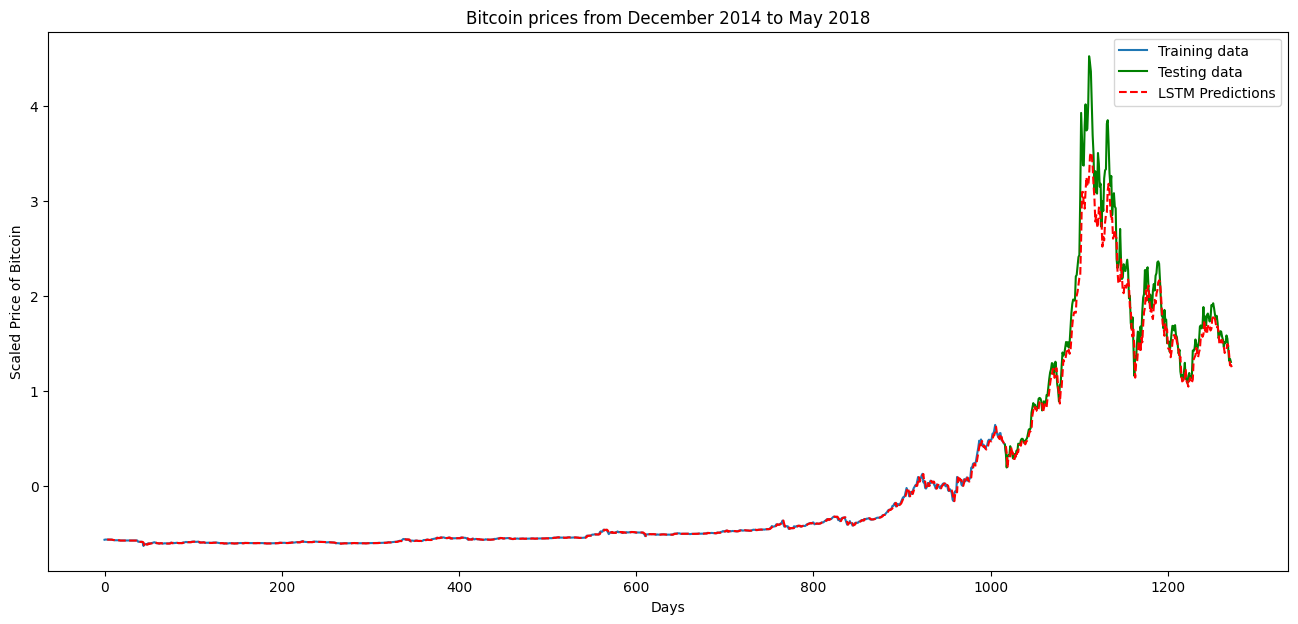

---

### V5

Vou tentar subir a taxa de aprendizado um pouco, já que o erro subiu.

**Parâmetros:**

- taxa de aprendizado = 0.0001
- early stopping:
    - delta = 0.07
    - paciência = 30

**Performance:**

- Train Loss: 0.0118
- Test Loss: 0.2544

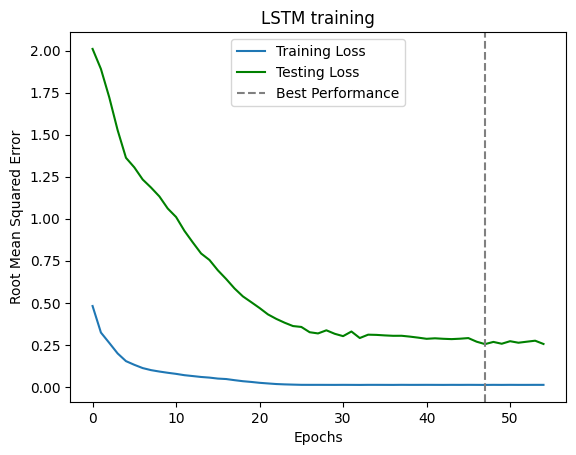

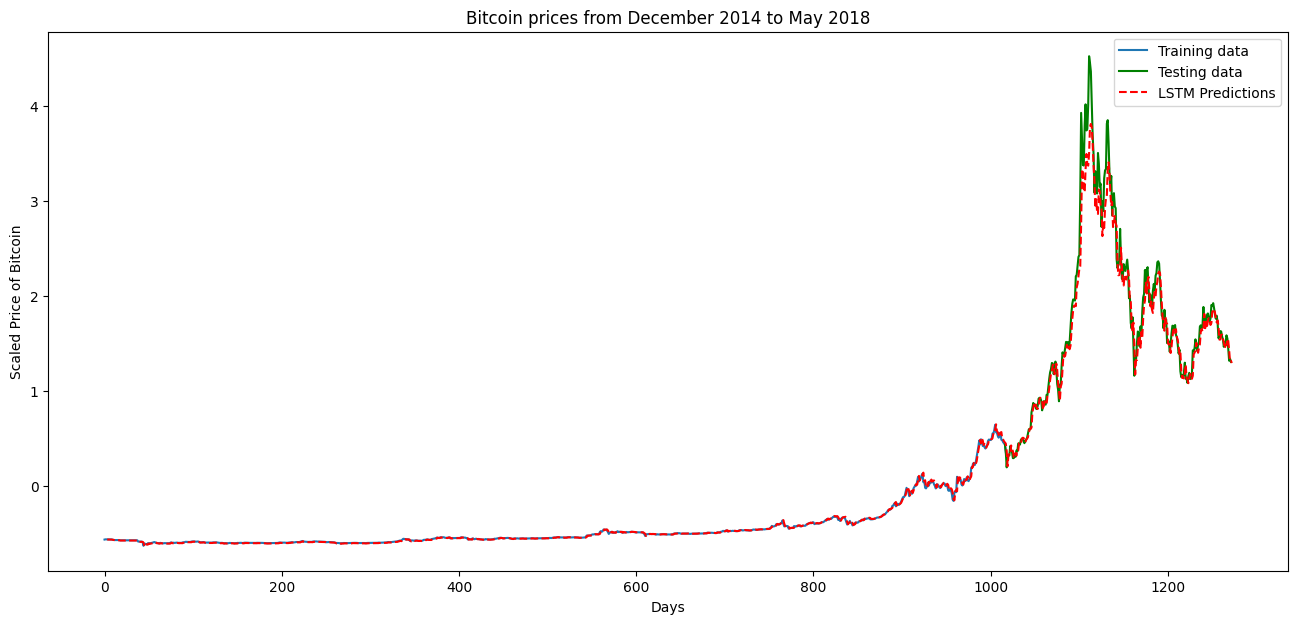

---

### V6

Já que o último modelo foi o melhor, possuindo a taxa de aprendizado (provavelmente) ideal, vou testar aumentar a quantidade de blocos LSTM para 2 (antes era apenas 1).


**Parâmetros:**

- número de blocos LSTM = 2

**Performance:**

- Train Loss: 0.0122
- Test Loss: 0.3407

Houve uma queda na performance, também testei rapidamente a mesma rede com alguns parâmetros diferentes então, em geral, 2 camadas LSTM tendem a ser piores nesse caso.

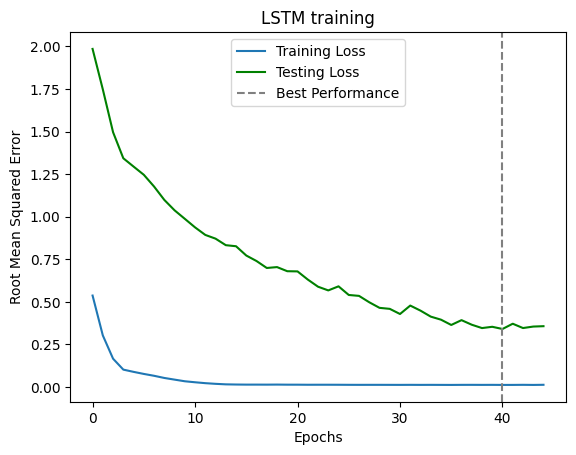

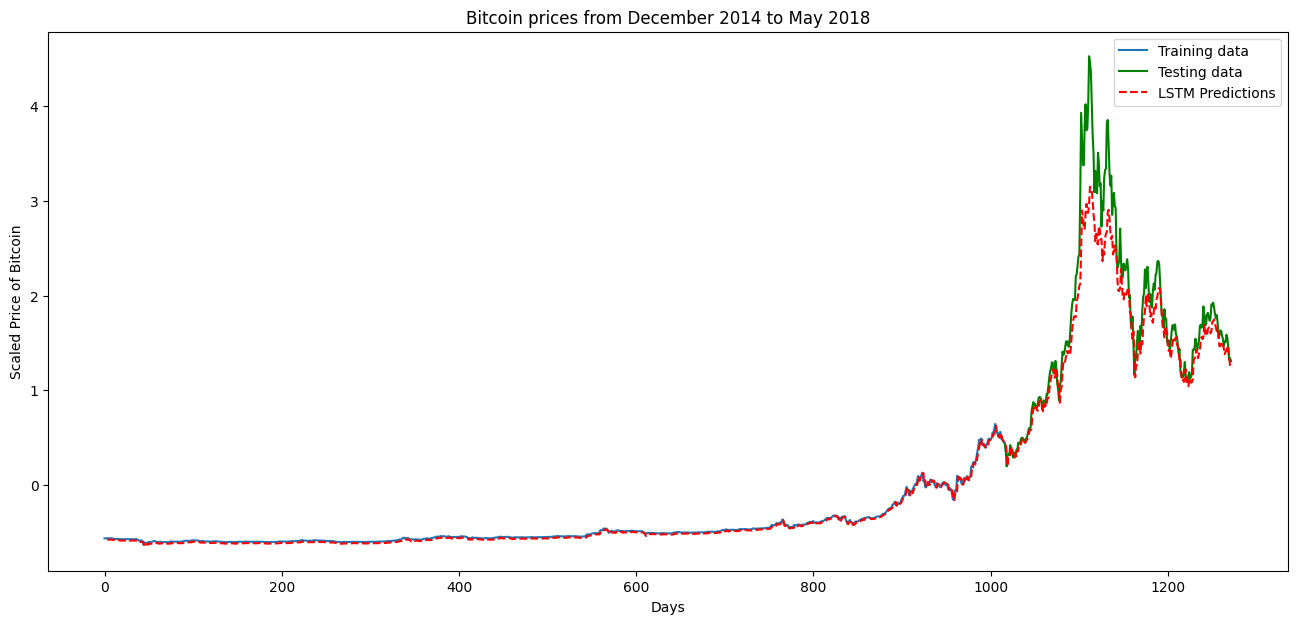

---
### V7

Vou testar aumentar a janela de recorrência (lookback) da rede para saber que tipo de impacto causa na performance.

**Parâmetros:**

- lookback = 7
- early stopping:
    - paciência = 50

**Performance:**

- Train Loss: 0.0125
- Test Loss: 0.2407

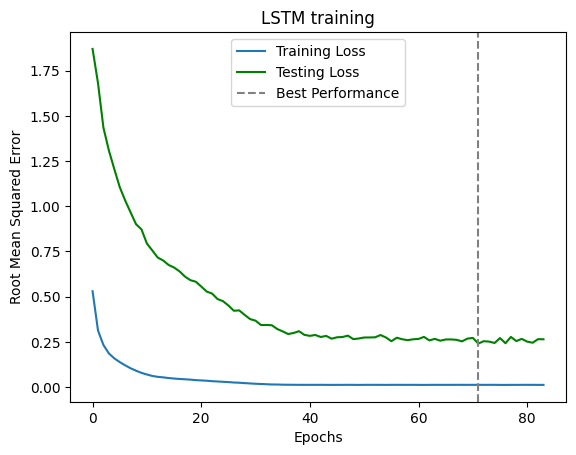

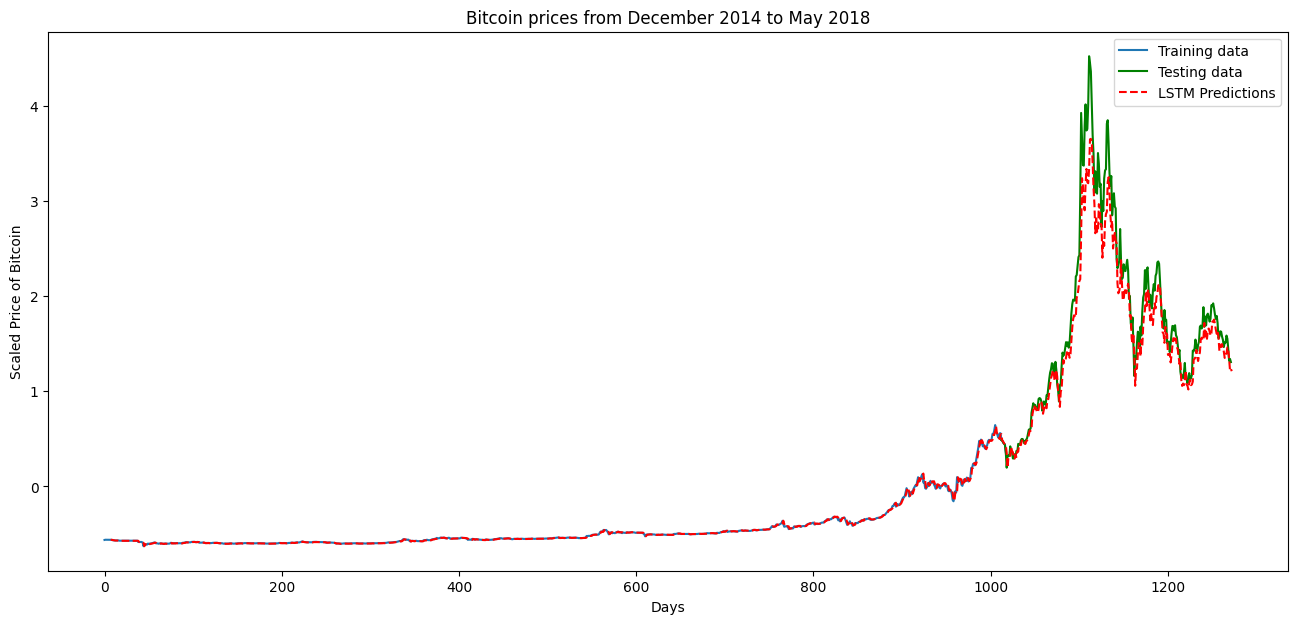

---

### V8

Já que o aumento do lookback melhorou a performance, vou tentar extrapolar.

- (Obs.: Nos testes anteriores, os conjuntos de treinamento e de teste se sobrepunham por algumas instâncias, graças a forma em que o conjunto de dados era repartido em janelas de recorrência, causando uma suposta melhora da performance no conjunto de teste; porém, esse erro foi corrigido após ter sido notado pelo aumento do tamanho dessas janelas nessa versão. Como o parâmetro lookback até então não teve um valor alto e a performance, em geral, não teve uma melhora significativa se compararmos com as versões futuras, eu não acho que devo desconsiderar os testes anteriores.)

**Parâmetros:**

- lookback = 100
- early stopping:
    - paciência = 30

**Performance:**

- Train Loss: 0.0112
- Test Loss: 0.2698

Apesar de considerar possível uma melhora no desempenho se aumentar a paciência do early stopping, não acho que faria mais sentido testar com esse "vácuo" de previsões do conjunto de treinamento, como mostra o 2º gráfico, até porque, uma das partes mais interessantes do conjunto de teste está sendo excluída, que é a grande explosão no preço do bitcoin, quando o valor chega mais alto.

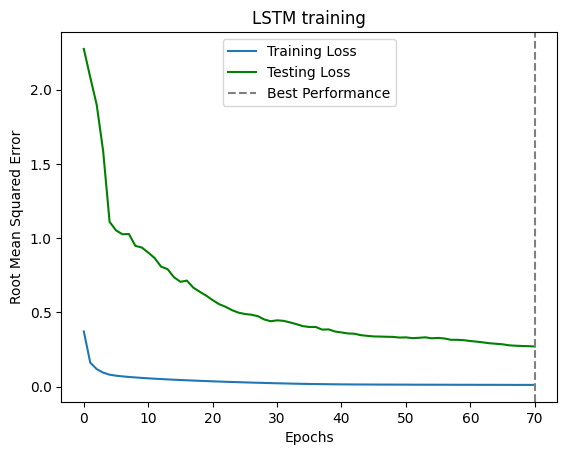

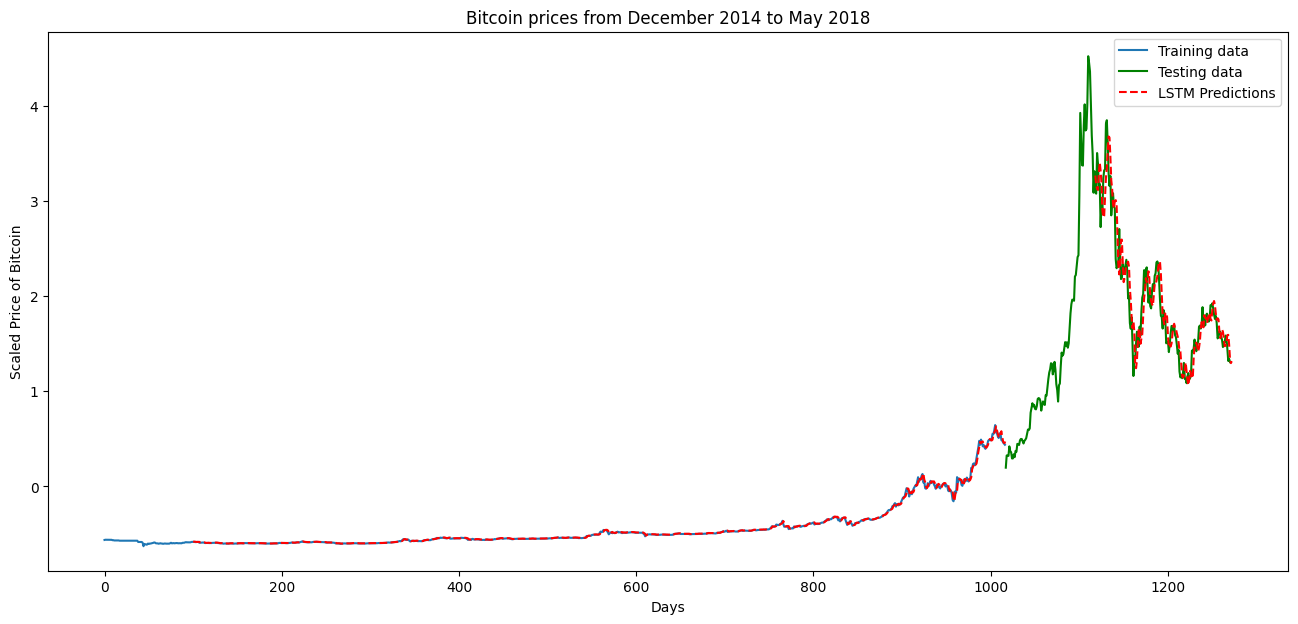

---

### V9

Agora vou tentar diminuir o lookback, já que extrapolei na versão anterior.

**Parâmentros:**

- lookback = 50

**Performance:**

- Train Loss: 0.0117
- Test Loss: 0.2444

Apesar de ter tido uma ótima performance, quando o modelo possui um lookback igual a 100, os resultados são mais melhores e mais consistentes, enquanto com janelas de recorrência mais baixas, a performance pode variar mais.

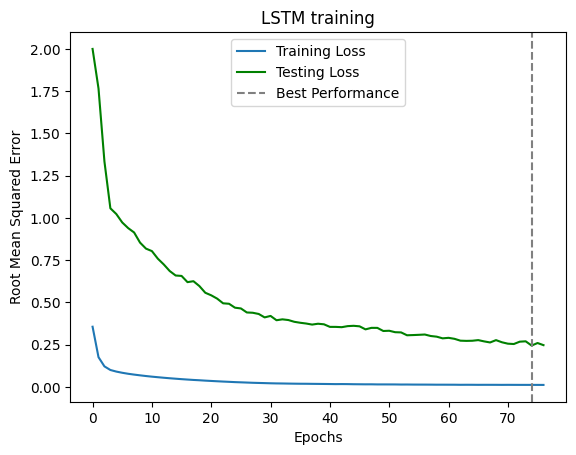

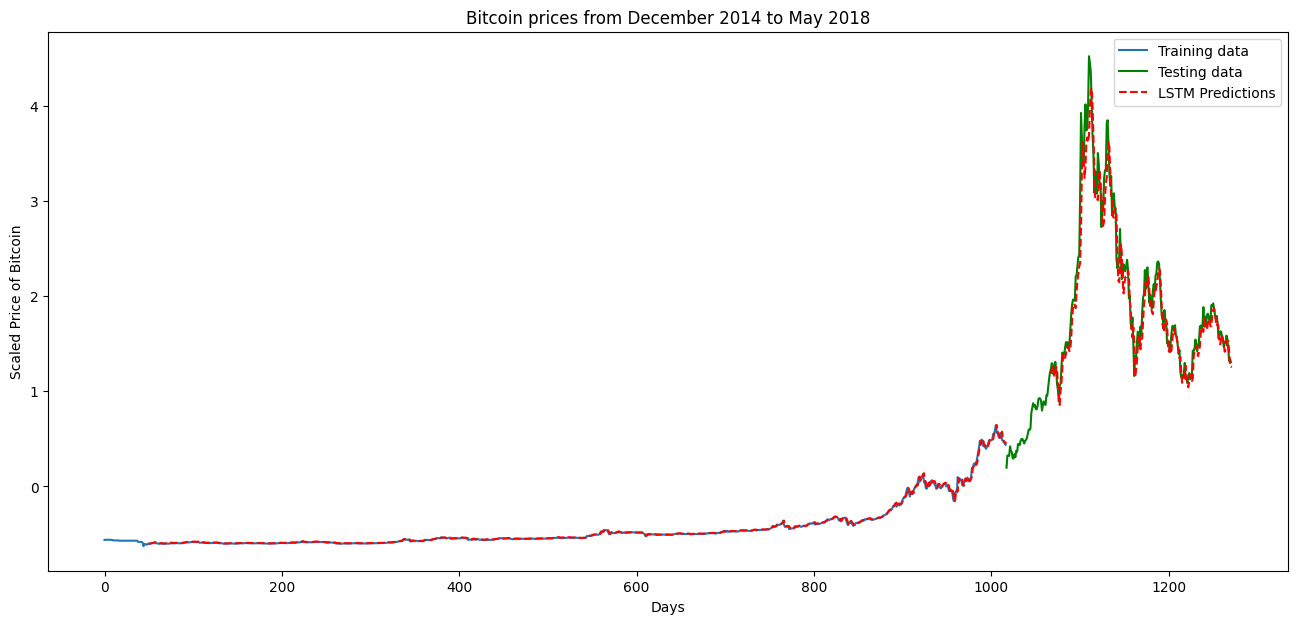

---

### V10 (melhor modelo...?)

Vou tentar diminuir ainda mais o lookback, para ver se a melhora na performance continua.

**Parâmetros:**

- lookback = 25

**Performance:**

- Train Loss: 0.0119
- Test Loss: 0.2334

Apesar de ter tido a melhor performance neste teste, em outros testes dessa mesma versão, a perda do conjunto de treinamento oscilava entre 0.24 e 0.26, então, mesmo que seja um intervalo pequeno, ainda tinha chance de não ter uma performance tão boa quanto as outras versões.

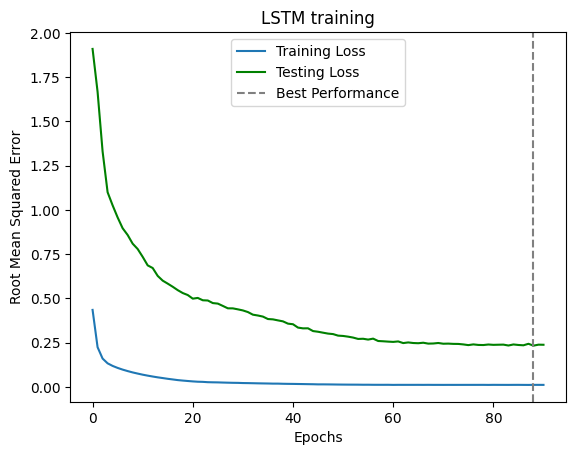

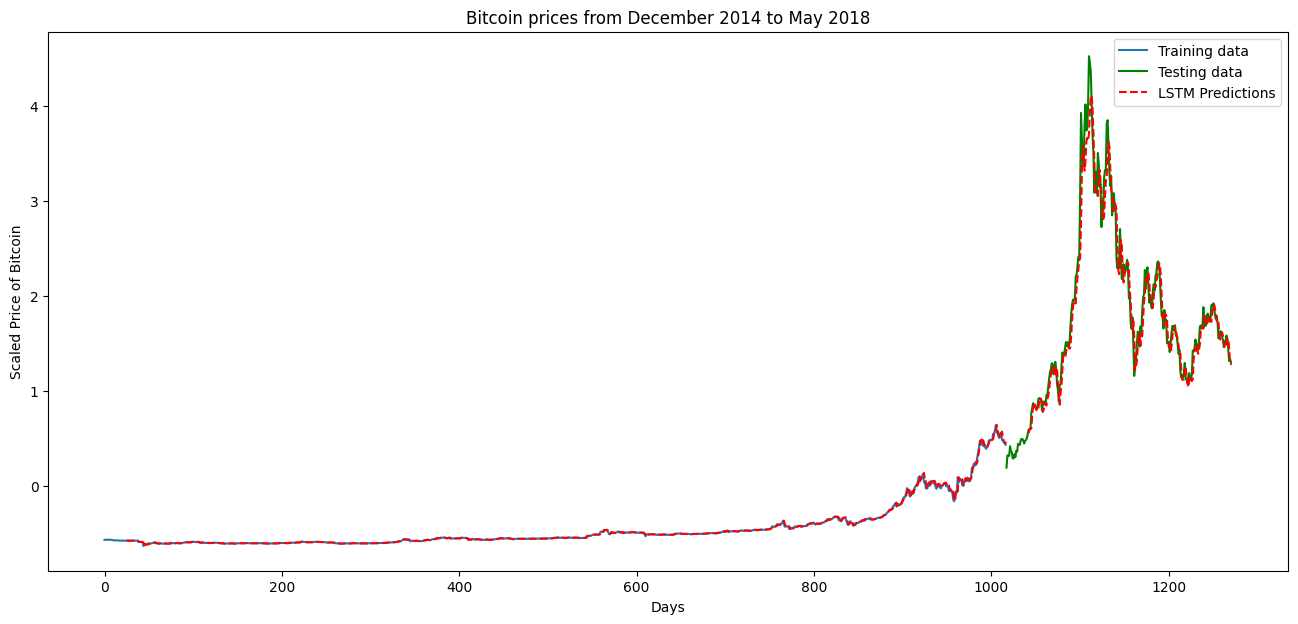

---

### V11

**Parâmentros:**

- lookback = 10

**Performance:**

- Train Loss: 0.0122
- Test Loss: 0.2399

Novamente, apresentando o mesmo problema da versão anterior, o RMSE do conjunto de teste oscila entre 0.24 e 0.26. Então posso ter certeza de que realmente, o tamanho da janela de recorrência não altera tanto a performance do modelo, a menos que essa janela seja muito grande (como no caso em que ficou igual a 100).

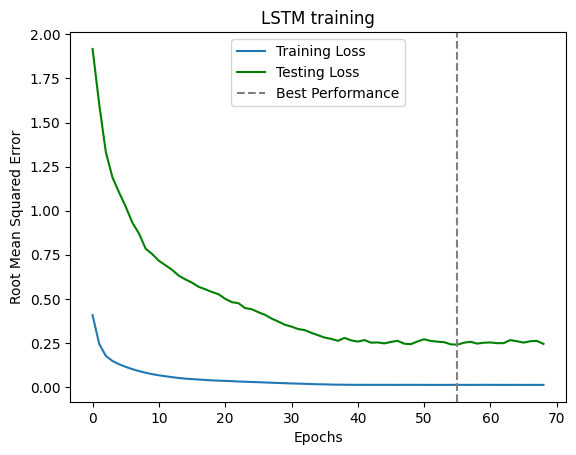

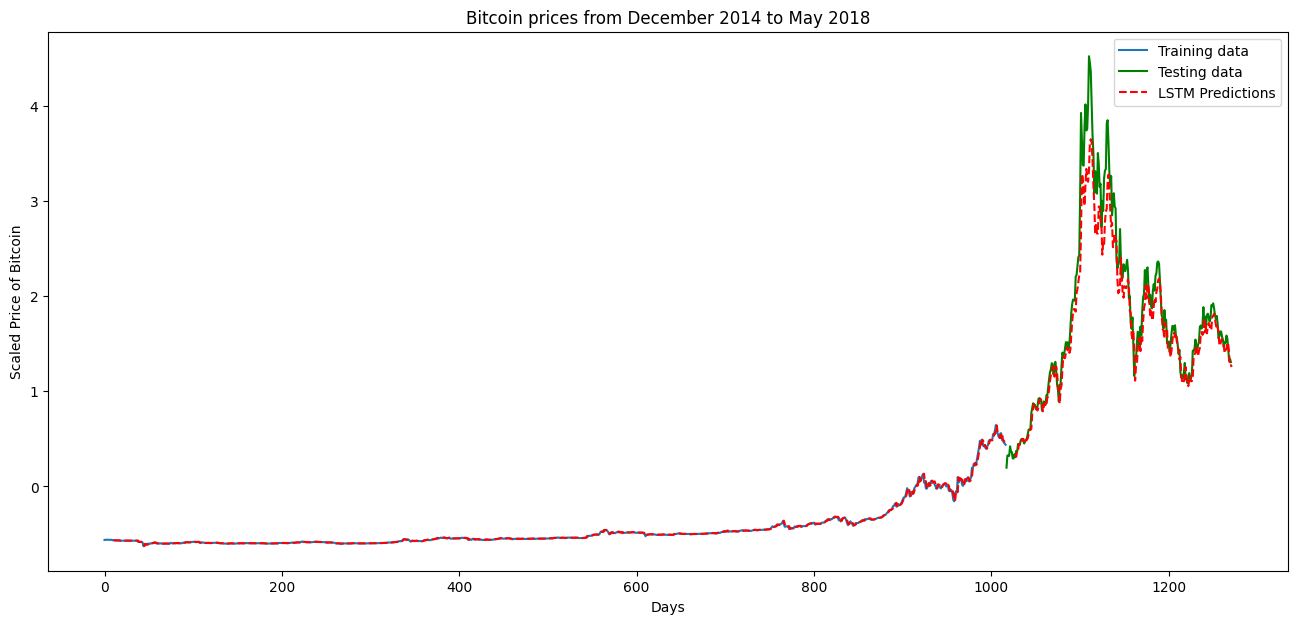

---

### V12

Mesmo tendo dito que não valeria a pena aumentar a paciência do early stopping nos comentários da V8, decidi fazer exatamente isso.

**Parâmetros:**

- early stopping:
    - paciência = 50

**Performance:**
- Train Loss: 0.0102
- Test Loss: 0.2371

Apresentou uma grande melhora, e que é consistente. O problema do vácuo no meio continua, então essa suposta melhora pode ser graças a parte mais difícil de ser prevista não ter sido prevista. Vou testar aumentar a paciência do melhor modelo até agora para ver se tem alguma melhora.

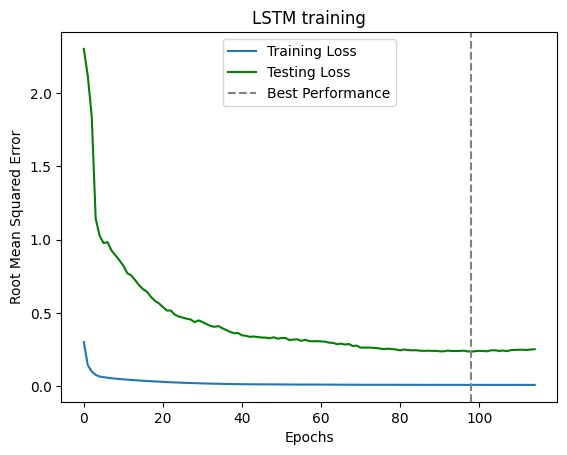

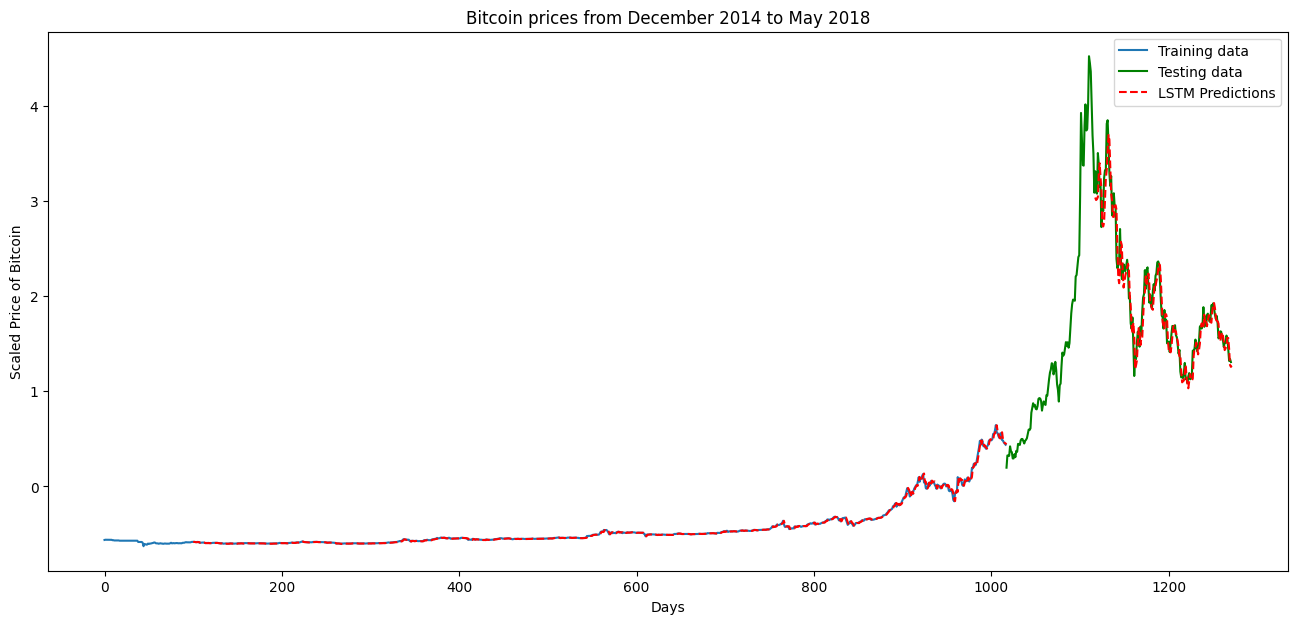

---

### V13

**Parâmetros:**

- lookback = 25

**Performance:**

- Train Loss: 0.0119
- Test Loss: 0.2581

Sem melhora significativa mesmo com o aumento da paciência. Esse resultado também mostra que os parâmetros da versão V10 não geram sempre o melhor modelo, caso contrário, teria conseguido um modelo tão bom quanto o da V10.

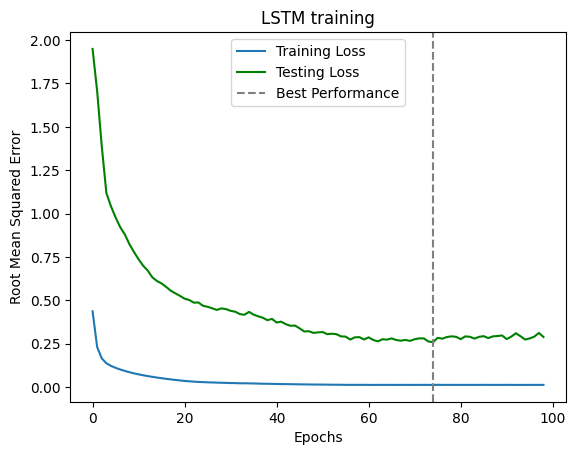

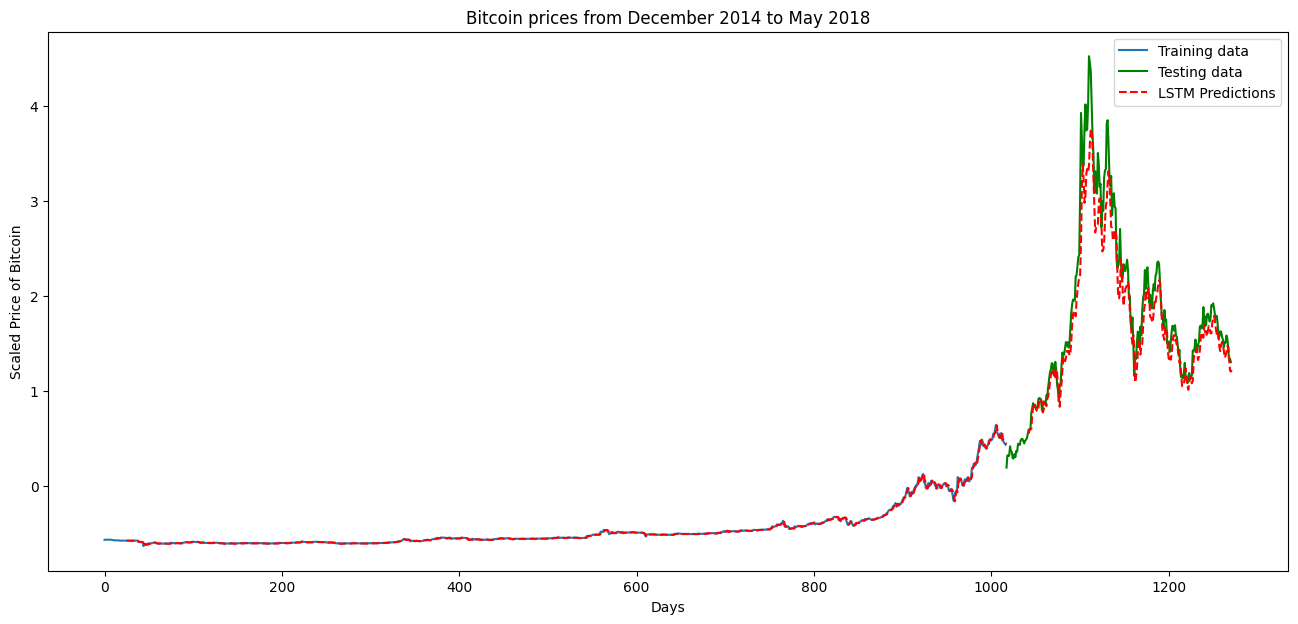

# Resultados

## Observações
- O fato do conjunto de teste ser bastante diferente da maioria do conjunto de treinamento com certeza impactou o resultado.

- O tamanho da janela de recorrência (lookback) só "melhorou" a performance quando recebeu um valor muito alto, tirando isso, ela não mostrou ser um fator tão importante nos resultados.
    - Como mencionado anteriormente, a suposta melhora não significa que o modelo se saiu melhor que os outros, mas sim porque o possível trecho mais difícil de se prever da série temporal não foi previsto.

- O aumento no número de camadas LSTM não ajudou, o que fazia sentido para mim, já que mais camadas poderiam significar uma melhor oportunidade de se adequar ao problema, mas não foi o que aconteceu. Isso foi igual aos problemas que tive com a MLP no mini-projeto passado.
    - Apesar de não ter sido apresentado no histórico, a diminiuição do número de features ocultas na célula LSTM causou uma queda da performance, enquanto o aumento não apresentou diferença nos resultados.

- Os melhores modelos obtiam um RMSE no conjunto de treinamento entre 0.24 e 0.26. Então não tenho como definir com certeza os melhores parâmetros, já que nenhum se destacou dentre os demais.

- O parâmetro mais significativo para a performance foi a taxa de aprendizado.